<a href="https://colab.research.google.com/github/abbyWoot/AML/blob/master/AML_Project3_JiahuiWu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Advanced Machine Learning Project3

@student: Jiahui Wu Abby

The CIFAR-10 dataset consists of 5 batches, named data_batch_1, data_batch_2, etc. As stated in the official web site, each file packs the data using pickle module in python.

The original one batch data is (10000 x 3072) matrix expressed in numpy array. The number of columns, (10000), indicates the number of sample data.
The row vector, (3072) represents an color image of 32x32 pixels.

In [0]:
#Set Up. 
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Load data from the CIFAR-10 datset

As mentionsed above, 32 X 32 is the size of each image. 
3 is the number of channels of the image. A RBG color image, has 3 channels.


In [5]:
from sklearn.datasets import fetch_openml 
#Was using fetch_mldata, and received an ImportError: cannot import name 'fetch_mldata' from 'sklearn.datasets
#using the tensflow to download the CIFAR-10 data
import tensorflow as tf
(X_train, y_train), (X_test, y_test)=tf.keras.datasets.cifar10.load_data()
print(f"Length of the X_train: {X_train.shape}, Length of y_train is: {y_train.shape}")
print(f"Length of the X_test:{X_test.shape}, Length of y_test is{y_test.shape}")

Length of the X_train: (50000, 32, 32, 3), Length of y_train is: (50000, 1)
Length of the X_test:(10000, 32, 32, 3), Length of y_test is(10000, 1)


tf.keras.datasets.cifar10.load_data() returns 2 tuples:

1, x_train, x_test: unit8 array of RGB image data with shape (number_samples, 3, 32, 32) or (number_samples, 32, 32, 3) based on the image_data_format backend setting of either channels_first or channels_last respectively.

2, y_train, y_test: uint8 array of category labels (integers in range 0-9) with shape (num_samples, 1).

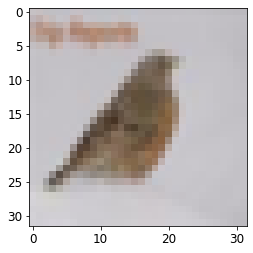

In [0]:
#playing
plt.figure(10)
img = plt.imshow(X_train[108])

Just For Fun

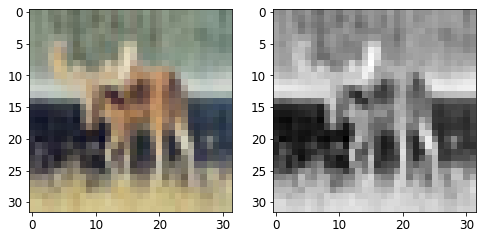

In [0]:
def grayscale(data, dtype='float32'):
    # luma coding weighted average in video systems
    r, g, b = np.asarray(.3, dtype=dtype), np.asarray(.59, dtype=dtype), np.asarray(.11, dtype=dtype)
    rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
    # add channel dimension
    rst = np.expand_dims(rst, axis=3)
    return rst

X_train_gray = grayscale(X_train)
X_test_gray = grayscale(X_test)

# now we have only one channel in the images
img_channels = 1

# plot a randomly chosen image
img = 28  #image number
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(X_train[img], interpolation='none')
plt.subplot(1, 2, 2)
plt.imshow(X_train_gray[img, :, :, 0], cmap=plt.get_cmap('gray'), interpolation='none')
plt.show()

In [0]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
def get_classes_index_by_name(name):
  if name == 'airplane' : return 0
  if name == 'automobile' : return 1
  if name == 'bird' : return 2;
  if name == 'cat' : return 3;
  if name == 'deer' : return 4;
  if name == 'dog' : return 5;
  if name == 'frog' : return 6;
  if name == 'horse' : return 7;
  if name == 'ship' : return 8;
  if name == 'truck' : return 9;
  sys.exit("uknown classes")

In [0]:
def visualize_sample(X_train, y_train, classes, samples_per_class=7):
    """visualize some samples in the training datasets """
    num_classes = len(classes)
    for y, cls in enumerate(classes):
        idxs = np.flatnonzero(y_train == y) # get all the indexes of cls
        idxs = np.random.choice(idxs, samples_per_class, replace=False)
        for i, idx in enumerate(idxs): # plot the image one by one
            plt_idx = i * num_classes + y + 1 # i*num_classes and y+1 determine the row and column respectively
            plt.subplot(samples_per_class, num_classes, plt_idx)
            plt.imshow(X_train[idx].astype('uint8'))
            plt.axis('off')
            if i == 0:
                plt.title(cls)
    plt.show()

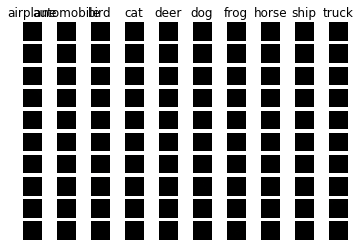

In [60]:
visualize_sample(X_train, y_train, classes, samples_per_class=10)

In [0]:
# As a sanity check, we print out th size of the training and test data dimenstion
print ('Train data shape: ', X_train.shape)
print ('Train labels shape: ', y_train.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)

Train data shape:  (50000, 32, 32, 3)
Train labels shape:  (50000, 1)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000, 1)


Normalize the data before processing(Scaling request in the excercise)

In [0]:
# normalize inputs from 0-255 to 0.0-1.0
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

In [0]:
#Convert the X_train and X_test data from 4d array into 2d array:
nsamples, nx, ny,nz = X_train.shape
d2_X_train = X_train.reshape((nsamples,nx*ny*nz))
nsamples, nx, ny, nz = X_test.shape
d2_X_test = X_test.reshape((nsamples,nx*ny*nz))

In [0]:
#Train the Random Forest Classifier and capture the time taken to train the orginal model
#import library
from sklearn.ensemble import RandomForestClassifier
import time
#initial the model
rnd_clf = RandomForestClassifier()
start_time = time.time()
#Train the model
rnd_clf.fit(d2_X_train, y_train)
print("Time is taken by model:","— %s seconds —"% (time.time()-start_time))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


Time is taken by model: — 280.03242921829224 seconds —


In [0]:
#Perfom the prediction on test data
y_predict = rnd_clf.predict(d2_X_test)

#Measure the accurancy of the Classifier
from sklearn.metrics import accuracy_score
print(f"Accuracy is {accuracy_score(y_predict, y_test) * 100}%")

Accuracy is 46.54%


use PCA to reduce the dataset's dimensionality, with an explained variance ratio of 95%.

In [84]:
#Use PCA to reduce the dataset's dimensionality, with an explained variance ratio of 95%
from sklearn.decomposition import PCA
import time
pca = PCA(n_components = .95) #This will insure that 95% variance is covered
time1=time.time()
X_train_pca = pca.fit_transform(d2_X_train)
print("PCA took {:.1f}s.".format(time.time() - time1))

#Verify the redued shape before we start training new model
#print(f"X_train shape is {d2_X_train.shape} and X_train_reduced shape is {X_train_reduced.shape}")
print(f"X_train shape is {d2_X_train.shape} and X_train_pca shape is {X_train_pca.shape}")

PCA took 75.5s.
X_train shape is (50000, 3072) and X_train_pca shape is (50000, 217)


Train the dimensionality reduced model with Random Forest, and calculating the time. 

In [0]:
start_time2 = time.time() 
rnd_clf.fit(X_train_pca, y_train) #Train the model 
print("Time is taken by model:","— %s seconds —"% (time.time()-start_time2))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Time is taken by model: — 121.14815711975098 seconds —


In [0]:
X_test_reduced = pca.transform(d2_X_test) #Reduce the dimensionality first
y_predict2 = rnd_clf.predict(X_test_reduced) #Predic the values using Model
print(f"Accuracy is {accuracy_score(y_predict2, y_test)* 100} %") #Print the accuracy

Accuracy is 44.14 %


Now we'll use t-SNE to reduce dimensionality down to 2D so we can plot the dataset. Current dimension is 3072

In [0]:
#Dimensionality reduction on the full 50,000 images takes a very long time, so we are doing this on a random subset of 10,000 images:
import numpy as np 
np.random.seed(42)

train_set = 10000 
idx = np.random.permutation(50000)[:train_set] 
X = d2_X_train[idx] 
y = y_train[idx]
print(f"Length of the X : {X.shape}, Length of y is : {y.shape}")

from sklearn.manifold import TSNE 

t0 = time.time()
tsne_red = TSNE(n_components=2, random_state=42) 
X_reduced = tsne_red.fit_transform(X)
t1 = time.time()
print("t-SNE took {:.1f}s.".format(t1 - t0))

Length of the X : (10000, 3072), Length of y is : (10000, 1)
t-SNE took 859.0s.


Train the dimensionality reduced model （used t-SNE）） with Random Forest, and calculating the time. 

In [0]:
start_time3 = time.time() 
rnd_clf.fit(X_reduced, y) #Train the model 
print("Time is taken by model:","— %s seconds —"% (time.time()-start_time3))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Time is taken by model: — 1.993208885192871 seconds —


In [0]:
X_test_reduced2 =tsne_red.fit_transform(d2_X_test) #Reduce the dimensionality first
y_predict3 = rnd_clf.predict(X_test_reduced2) #Predic the values using Model
print(f"Accuracy is {accuracy_score(y_predict3, y_test)* 100} %") #Print the accuracy

Accuracy is 12.889999999999999 %


WOW t-SNE took a super long time to reduce dimensionality: 858.8 seconds!! And the accuracy with the t-SNE processed data is super low, 12.9 % accuracy. 
Compare to t-SNE, PCA is much faster, and has higher accuracy in this case. However 43% is not that high either. I'll study more, and try to figure out better methods to use. 




### **Binary classifiers**


In [54]:
#print(get_classes_index_by_name('horse'));
#print(y_train)
d1_y_train = y_train.ravel()

y_train_H = (d1_y_train == get_classes_index_by_name('horse'))
y_test_H = (y_test == get_classes_index_by_name('horse'))

#y_train_H = (y_train == get_classes_index_by_name('horse'))
#y_test_H = (y_test == get_classes_index_by_name('horse'))

y_train_H
#d2_X_train[get_classes_index_by_name('horse')]

array([False, False, False, ..., False, False, False])

In [59]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(d2_X_train, y_train_H)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [56]:
some_digit = d2_X_train[get_classes_index_by_name('horse')]
sgd_clf.predict([some_digit])

array([ True])

**Cross Validation Score**

In [57]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, d2_X_train, y_train_H, cv=3, scoring="accuracy")

array([0.90226195, 0.89956201, 0.8876155 ])

### **K-Fold**

In [63]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_H):
    clone_clf = clone(sgd_clf)
    X_train_folds =d2_X_train[train_index]
    y_train_folds = y_train_H[train_index]
    X_test_fold =d2_X_train[test_index]
    y_test_fold = y_train_H[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.9022619547609048
0.8995620087598248
0.8876155046201848


The StraitifiedKFold class performs stratified smpling to produce folds that contain a representative ratio of each class. It counts the number of correct predictions and outputs the ratio of correct predictions. 

In [0]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [69]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, d2_X_train, y_train_H, cv=3, scoring="accuracy")

array([0.89878202, 0.89938201, 0.90183607])

Wow! Around 90% accuracy! This is simply because 10% of the images are hourses, so if you always guess that an image is not hourse, you will be right about 90% of the time. 

### **Confusion Matrix**

make predictions on the test set.
Just like the cross_val_score() function, cross_val_predict() performs ***K-fold cross-validation**, but instead of retruning the evaluation scores, it returns the predictions made on each test fold. 

In [0]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, d2_X_train, y_train_H, cv=3)

In [72]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_H, y_train_pred)

array([[43487,  1513],
       [ 3663,  1337]])

The first row of this matrix considers non-horse images: 43487 of them were correctly classified as non-horses (true negative); 1513 were wrongly classified as horses (false positive); The second row considers the images of 5s(positive class): 3663 were wrongly classified as non-horses(false negative); 1337 were correctly classified as horses (true positives); 

In [73]:
y_train_perfect_predictions = y_train_H  # pretend we reached perfection
confusion_matrix(y_train_H, y_train_perfect_predictions)

array([[45000,     0],
       [    0,  5000]])

In [76]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_H, y_train_pred)


0.4691228070175439

***Precision**

precision = TP/(TP + FP), it's the accuracy of the positive predictions. 

In [77]:
print("1337/(1337+1513) = ", 1337/(1337+1513) )

1337/(1337+1513) =  0.4691228070175439


***Recall**

recall = TP/(TP+FN), it's the ratio of positive instances that are correctly detected by the classifier

In [78]:
recall_score(y_train_H, y_train_pred)

0.2674

In [79]:
print("1337/(1337+3663) = ", 1337/(1337+3663) )

1337/(1337+3663) =  0.2674


For fun

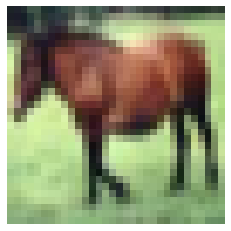

In [58]:
randomX = d2_X_train[get_classes_index_by_name('horse')]
randomX_image = randomX.reshape(32, 32,3)
plt.imshow(randomX_image, cmap=mpl.cm.binary)
plt.axis("off")

plt.show()

### **Multiclass classifiers**
**SVM**

We have already predited using Random Forest Above.
Now we are using SVM to predict, using PCA dimentionalisy-reduced data


In [36]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(d2_X_train[:1000], y_train[:1000]) 
svm_clf.predict([randomX])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([6], dtype=uint8)

In [38]:
randomX_scores = svm_clf.decision_function([randomX])
randomX_scores

array([[-0.30416998,  6.24971667,  2.9367128 ,  6.24332789,  8.28665762,
         4.20160149,  9.30097659,  6.23568753,  0.69936942,  1.72025499]])

In [39]:
np.argmax(randomX_scores)

6

In [40]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [44]:
svm_clf.classes_[7]

7

In [47]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(d2_X_train[:1000], y_train[:1000])
ovr_clf.predict([randomX])

array([6], dtype=uint8)

In [48]:
len(ovr_clf.estimators_)

10

In [89]:
sgd_clf.fit(d2_X_train, y_train)
sgd_clf.predict([randomX])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


KeyboardInterrupt: ignored